## Get Data

In [2]:
from fastbook import *
from fastai.vision.widgets import *

/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [4]:
if not path.exists():
    path.mkdir()
    for bt in bear_types:
        dest = (path/bt)
        dest.mkdir(exist_ok=True)
        urls = search_images_ddg(f'{bt} bear')
        download_images(dest, urls=urls)

In [5]:
fns = get_image_files(path)
fns

(#540) [Path('bears/teddy/da2effa0-0007-4a72-8f5c-a8a2166a33d8.jpg'),Path('bears/teddy/2081f210-0881-48ad-984a-1e2fd31bc1ad.jpg'),Path('bears/teddy/ebc1d476-6edf-4a5f-a26f-da742f53f7d3.jpg'),Path('bears/teddy/f50c3fdf-bbb4-4171-be9b-3a3c9acb99c2.jpg'),Path('bears/teddy/3fd059c8-b169-4dcf-92c8-acdf445b3eb8.jpg'),Path('bears/teddy/2893e8b3-e1c3-44f6-a5cf-bfb7e900313b.jpg'),Path('bears/teddy/b3ccbc1e-bf10-425f-91d8-dc698d5d8f84.jpg'),Path('bears/teddy/e0785240-d645-4f62-aa50-cda3896ac61c.jpg'),Path('bears/teddy/752feed5-1a3d-46a6-aa14-055986d1c739.jpg'),Path('bears/teddy/0df47ca5-5c43-4f6a-97f9-cf0487da38fc.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink)

(#0) []

## From data to dataloader

To train a model, we'll need `DataLoaders`, which is an iterator that provides a stream of mini-batches, where each mini-batch is a couple of batches of independent variables and a batch of dependent variables.

To build a DataBlock, there are several steps that needs to be followed. These steps can be asked in the form of questions 
1. What is the types of your input/labels? `Blocks`
2. Where is your data? `get_items`
3. Does something need to be applied to inputs/labels? `get_x, get_y`
4. How to split the data? `splitter`
5. Do we need to apply something on formed items? `item_tfms`
6. Do we need to apply something on formed batches? `batch_tfms`

In [8]:
# DataBlock: Generic container to quickly build Datasets and DataLoaders.
#            blocks(List): One or more Transform blocks.
#                          blocks are used to define a pre-defined problem domain.
#                          e.g, ImageBlock, CategoryBlock, MultiCategoryBlock, TextBlock etc
#                          CategoryBlock: TransformBlock for single-label categorical targets
#            get_items:    Where is the data?
#                          We can use get_image_files function to go grab all the file locations 
#                          of our images.
#            get_y:        How you extract labels. 
#            splitter:     How to split your data. This is usually a random split between the training and 
#                          validation dataset.
#            item_tfms:    Item transform applied on an individual item basis. This is done on the CPU.

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Above command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [9]:
dls = bears.dataloaders(path)

A `DataLoaders` includes **validation** and **training** `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

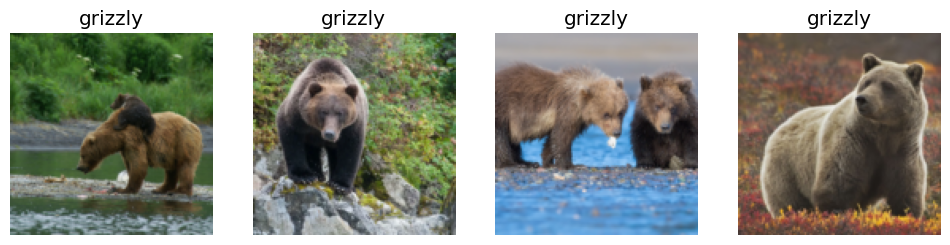

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

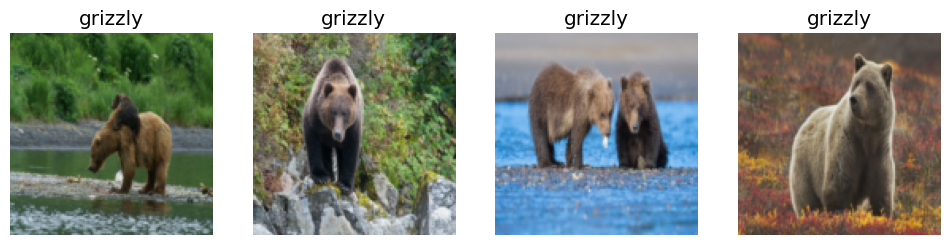

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

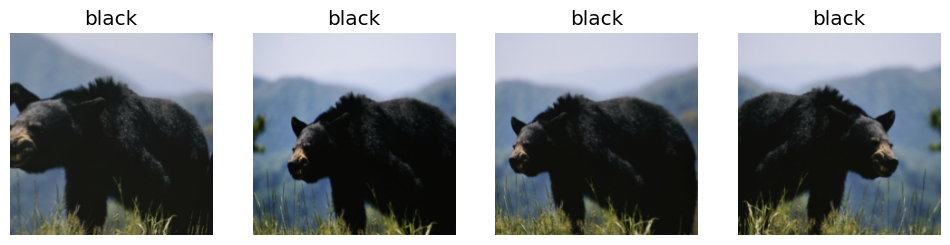

In [12]:
# In practice, below is used
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.219862,0.138688,0.046296,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.157743,0.088138,0.018519,00:26
1,0.136046,0.098805,0.018519,00:26
2,0.105934,0.109753,0.018519,00:26
3,0.102335,0.096271,0.018519,00:28
4,0.083066,0.095921,0.018519,00:27


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

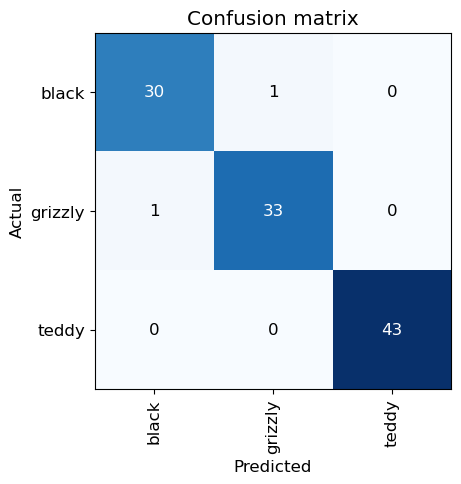

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer.

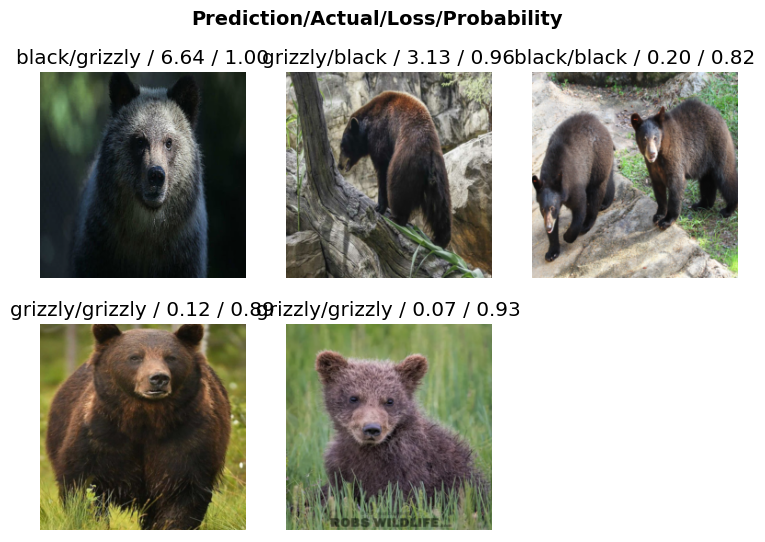

In [15]:
interp.plot_top_losses(5, nrows=2)

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [16]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

## Turning Your Model into an Online Application

Model consists of two parts: a) The architecture b) Trained parameters.
To save both parts, use the `export` method. When you call 'export', fastai will save a file called 'export.pkl'. You'll need this file wherever you deploy your app to. 

In [19]:
learn.export()

In [20]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [53]:
learn = load_learner(path/'export.pkl')

In [61]:
urls = search_images_ddg(f'black bear')
dest = 'images/black.jpg'
download_url(urls[0], dest)

Path('images/black.jpg')

In [62]:
learn.predict('images/tiger.jpg')

('grizzly', TensorBase(1), TensorBase([0.0026, 0.9950, 0.0024]))

In [63]:
learn.dls.vocab

['black', 'grizzly', 'teddy']

#### Gradio interface

In [76]:
categories = ('black', 'grizzly', 'teddy')
def classify_image(im):
    pred, idx, probs = learn.predict(im)
    return dict(zip(categories, map(float, probs)))

In [77]:
classify_image('images/grizzly.jpg')

{'black': 3.1121854249249736e-07,
 'grizzly': 0.9999899864196777,
 'teddy': 9.62804551818408e-06}

The core Interface class of gradio(https://gradio.app/) is initialized with three required parameters:
- fn: the function to wrap a UI around
- inputs: which component(s) to use for the input (e.g. "text", "image" or "audio")
- outputs: which component(s) to use for the output (e.g. "text", "image" or "label")

In [78]:
import gradio as gr
image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = ['images/grizzly.jpg', 'images/black.jpg', 'images/teddy.jpg']
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False, share=True)

/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/ec2-user/anaconda3/envs/fastai/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://e9b6ac4185238d8338.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
